In [1]:
import sys
sys.path.insert(0, '../')
from lib.io_functions import load_npy, save_proccesed_variables
from lib.fit_functions import fit_wvfs,scfunc, gauss
from lib.sim_functions import rand_scint_times
from lib.wvf_functions import find_baseline_cuts, find_amp_decrease
from lib.dec_functions import deconvolve

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit


In [2]:
plt.rcParams.update({'font.size': 15})
timewindow = 800
pretrigger = 200
# Load data for wvf template (LARSOFT)
raw_SER = open("../larsoft/PDS/SPE_maritza.txt")
SER = np.asarray(raw_SER.readlines()).astype(float)

# Load data for wvf template (LAB)
# lab_run = load_npy([2],[6],"Average_","../data/ave/")
# SER = lab_run[2][6]["SPEAvWvf"]

# Load data for wvf template (LAB)
# lab_run = load_npy([2],[0],"Average_","../data/ave/")
# SER = lab_run[2][0]["SPEAvWvf"]

# Generate empty array to import data
SER = np.append(np.asarray(SER),np.zeros(timewindow))
SER = np.append(np.zeros(pretrigger),np.asarray(SER))

# Generate dict with required structure
my_run = dict()
my_run["NRun"] = [0]
my_run["NChannel"] = [0]
my_run[0] = dict()
my_run[0][0] = dict()
my_run[0][0]["ADC"] = [np.array(SER)]
my_run[0][0]["Sampling"] = 16e-9

opt = {
    "SHOW": False,
    "NOISE_AMP": 0.5,
    "FIX_EXP":True,
    "WIENER_BUFFER": 100,
    "FILTER": "Gauss",
    "PRO_RODRIGO": False,
    "CONVERT_ADC": True,
    "TERMINAL_OUTPUT": False
    }
    
param = fit_wvfs(my_run,"SC",1e-4,fit_range=[0,len(SER)-timewindow],out_key="SPE",OPT=opt)
i_base_idx,f_base_idx = find_baseline_cuts(my_run[0][0]["FitSCSPE"][0])
i_thrld_idx,f_thrld_idx = find_amp_decrease(my_run[0][0]["FitSCSPE"][0],1e-4)

pre = len(my_run[0][0]["FitSCSPE"][0][:i_thrld_idx])
post = len(my_run[0][0]["FitSCSPE"][0][i_thrld_idx:])

my_run[0][0]["FitSPEChargeADC"] = np.trapz(my_run[0][0]["FitSCSPE"][0][:f_base_idx],my_run[0][0]["Sampling"]*np.arange(f_base_idx))
my_run[0][0]["FitSPEUnderChargeADC"] = np.trapz(my_run[0][0]["FitSCSPE"][0][f_base_idx:],my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitSCSPE"][0][f_base_idx:])))
my_run[0][0]["SPEChargeADC"] = np.trapz(my_run[0][0]["ADC"][0][:f_base_idx],my_run[0][0]["Sampling"]*np.arange(f_base_idx))
my_run[0][0]["SPEUnderChargeADC"] = np.trapz(my_run[0][0]["ADC"][0][f_base_idx:],my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0][f_base_idx:])))

print(np.sum(my_run[0][0]["ADC"][0]))
print(100*my_run[0][0]["SPEChargeADC"]/(-my_run[0][0]["SPEUnderChargeADC"]))




Fitting wvf  0


-0.9459754105999989
92.4366077407921


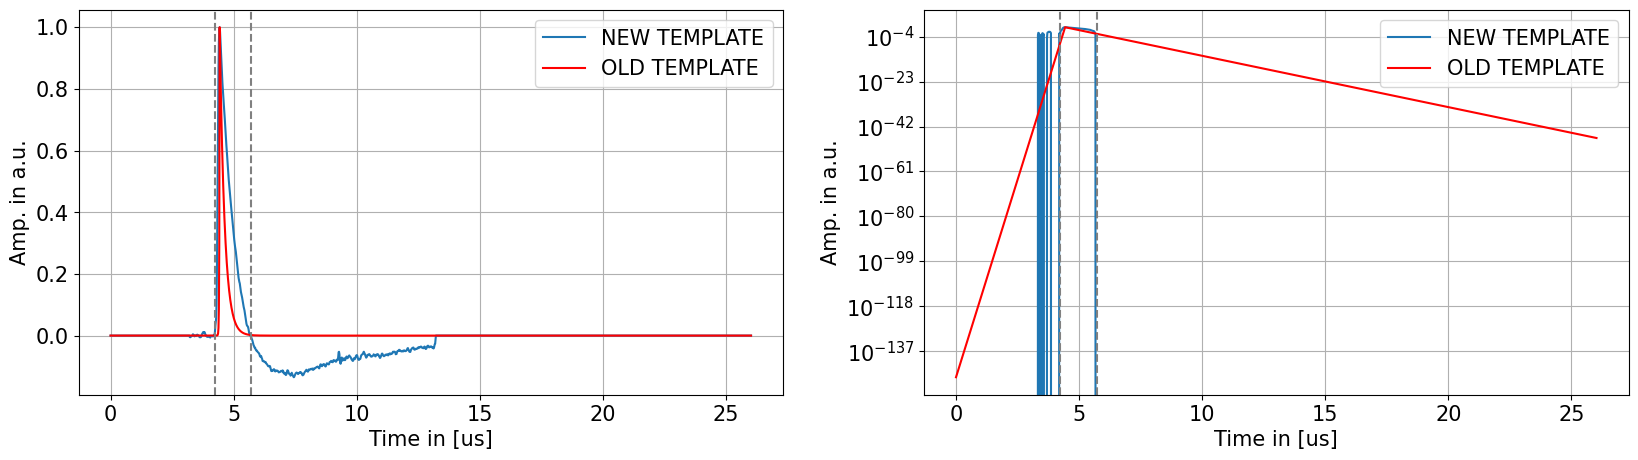

In [3]:
def larsoft_template(time_in_us,fPeakTime,fVoltageToADC,fMaxAmplitude,fFrontTime,fBackTime):    
    template = []
    for i in time_in_us:
        if (i < fPeakTime):
            template.append(fVoltageToADC*fMaxAmplitude*np.exp((i - fPeakTime)/fFrontTime))
        else:
            template.append(fVoltageToADC*fMaxAmplitude*np.exp(-(i - fPeakTime)/fBackTime))
    return np.asarray(template)

fig, ax = plt.subplots(1 ,2, figsize = (20,5))
time_array = 1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitSCSPE"][0]))
peaktime = 1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["FitSCSPE"][0]))
# print(time_array.size)
for i in range(len(ax)):
    # ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0],label="NEW TEMPLATE")
    ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0]/np.max(my_run[0][0]["ADC"][0]),label="NEW TEMPLATE")
    # ax[i].plot(time_array,my_run[0][0]["FitSCSPE"][0],label="TEMPLATE FIT")
    ax[i].plot(time_array,larsoft_template(time_array,peaktime,151.5,0.066,0.013,0.2)/np.max(larsoft_template(time_array,peaktime,151.5,0.066,0.013,0.2)),label="OLD TEMPLATE",c="red")
    ax[i].axvline(1e6*my_run[0][0]["Sampling"]*i_thrld_idx,ls="--",c="grey")
    ax[i].axvline(1e6*my_run[0][0]["Sampling"]*f_thrld_idx,ls="--",c="grey")
    # ax[i].axvline(1e6*my_run[0][0]["Sampling"]*np.argmax(my_run[0][0]["FitSCSPE"][0]),c="black",label="RISE TIME: %.2f"%(1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["FitSCSPE"][0])-i_thrld_idx)))
    ax[i].set_ylabel("Amp. in a.u.")
    ax[i].set_xlabel("Time in [us]")
    ax[i].legend(fontsize=15)
    ax[i].grid(True)
    # ax[i].set_xlim([3.5,8])
ax[1].semilogy()
plt.show()

In [4]:
i_SPE_Fit_thrld_idx,f_SPE_Fit_thrld_idx = find_amp_decrease(my_run[0][0]["FitSCSPE"][0],1e-4)
my_run[0][0]["SER"] = []
my_run[0][0]["SER"].append(np.roll(my_run[0][0]["FitSCSPE"][0],-i_SPE_Fit_thrld_idx))

In [5]:
# %matplotlib qt

key = ["ADC","SER","DecADC"]
opt["CONVERT_ADC"] = False
opt["FILTER"] = "GAUSS"
# opt["SHOW_F_SIGNAL"] = True
# opt["SHOW_GAUSS_SIGNAL"] = False
opt["SHOW_F_GAUSS"] = True
# opt["SHOW_F_DET_RESPONSE"] = True
opt["SHOW_F_WIENER"] = True
# opt["SHOW_F_DEC"] = True
opt["SHOW"] = False

# One can substitute the template with a fit
# param = fit_wvfs(my_run,"SC",1e-4,fit_range=[0,len(SER)-timewindow],OPT=opt)
# max_idx = np.argmax(my_run[0][0][key[1]][0])


deconvolve(my_run,my_run,my_run,key,opt) # Sanity check deconvolution

opt["FILTER"] = "WIENER"
deconvolve(my_run,my_run,my_run,key,opt) # Sanity check deconvolution


Generated wvfs with key GaussDecADC
Generated wvfs with key WienerDecADC


In [6]:
# Compute SPE integrals
dec_label = ["Gauss","Wiener"]
int_range = 20
for label in dec_label:
    peak_max  = np.argmax(my_run[0][0][label+"DecADC"][0])
    my_run[0][0][label+"Peak"]     = peak_max
    my_run[0][0][label+"NoiseSTD"] = np.std(my_run[0][0][label+"DecADC"][0][2000:])
    my_run[0][0][label+"SPEInt1"]  = np.sum(my_run[0][0][label+"DecADC"][0][my_run[0][0][label+"Peak"]-int_range*1:my_run[0][0][label+"Peak"]+int_range*1])
    my_run[0][0][label+"SPEInt2"]  = np.sum(my_run[0][0][label+"DecADC"][0][my_run[0][0][label+"Peak"]-int_range*2:my_run[0][0][label+"Peak"]+int_range*2])
    my_run[0][0][label+"SPEInt3"]  = np.sum(my_run[0][0][label+"DecADC"][0][my_run[0][0][label+"Peak"]-int_range*3:my_run[0][0][label+"Peak"]+int_range*3])
    print(my_run[0][0][label+"SPEInt1"])
    print(my_run[0][0][label+"SPEInt2"])
    print(my_run[0][0][label+"SPEInt3"])
    print(my_run[0][0][label+"NoiseSTD"])

1.0033385547092752
0.998429564062836
0.994651072923926
nan
0.6378723519270858
0.6589401202399918
0.6368830060853887
nan


/home/smanthey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/smanthey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/smanthey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


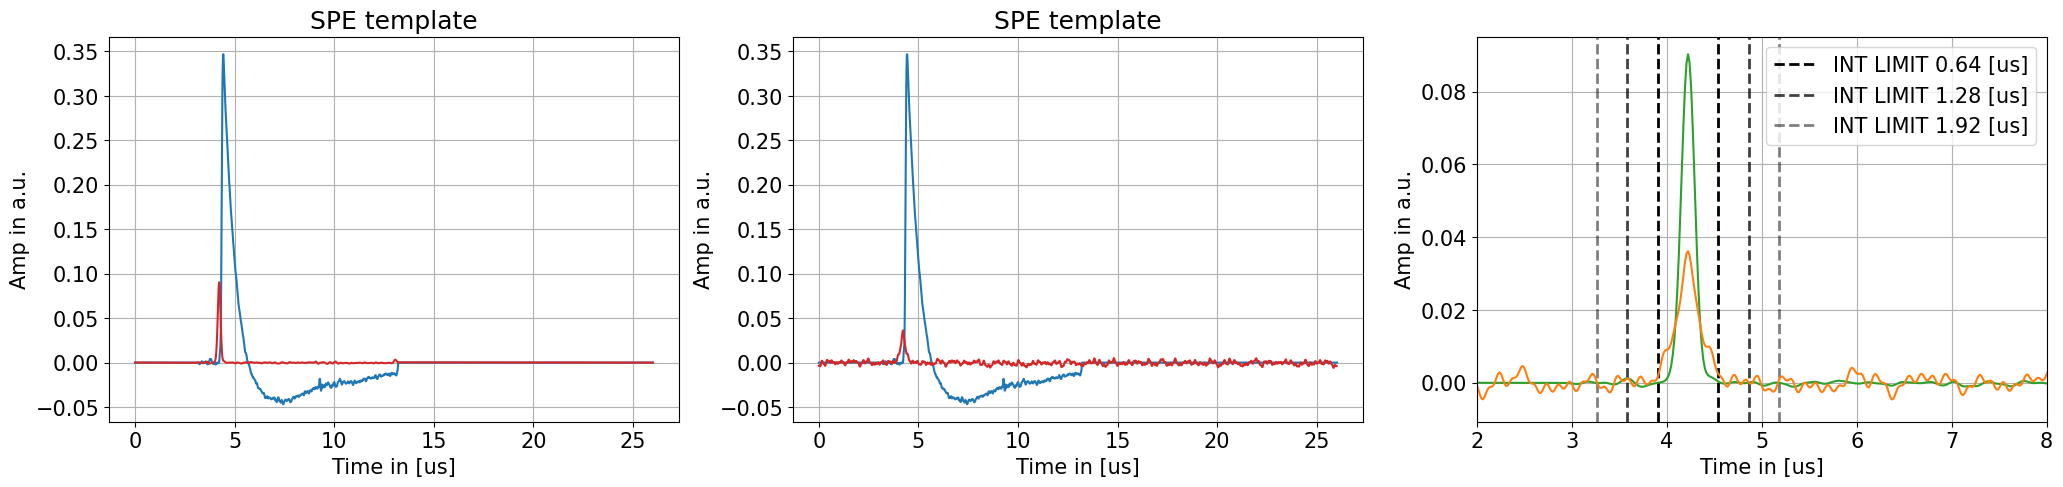

In [7]:
fig,ax = plt.subplots(1,3,figsize=(25,5))
for i in range(len(ax)):
    ax[i].grid(True)
for i in range(len(ax)):            
    if i == 0 or i == 1: 
        ax[i].set_title("SPE template")
        ax[i].set_xlabel("Time in [us]")
        ax[i].set_ylabel("Amp in a.u.")
        ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][key[0]][0])),my_run[0][0]["ADC"][0],label="LARSOFT X-ARAPUCA TEMPLATE")
        ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][dec_label[i]+key[2]][0])),my_run[0][0][dec_label[i]+key[2]][0],c="tab:red")
    else:
        for ii in range(3):
            ax[i].axvline(1e6*my_run[0][0]["Sampling"]*(my_run[0][0][label+"Peak"]-int_range*(ii+1)),ls="--",lw=2,c="k",alpha=1-0.25*(ii),label="INT LIMIT %.2f [us]"%((1+ii)*2*int_range*1e6*my_run[0][0]["Sampling"]))
            ax[i].axvline(1e6*my_run[0][0]["Sampling"]*(my_run[0][0][label+"Peak"]+int_range*(ii+1)),ls="--",lw=2,c="k",alpha=1-0.25*(ii))

ax[2].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Gauss"+key[2]][0])),my_run[0][0]["Gauss"+key[2]][0],c="tab:green")
ax[2].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Wiener"+key[2]][0])),my_run[0][0]["Wiener"+key[2]][0],c="tab:orange")
ax[2].set_xlabel("Time in [us]")
ax[2].set_ylabel("Amp in a.u.")
ax[2].legend()
ax[2].set_xlim([2,8])
plt.show()

In [8]:
MC_num = 1000
buffer = 400
my_run[0][0]["McADC"] = []
my_run[0][0]["Mct0"] = []
for i in range(MC_num):
    times = rand_scint_times(100,fast=6e-9,slow=1.4e-6,ratio=0.7)
    peaks = [];wvf = []; this_wvf = []

    times_array = np.linspace(0,20e-6,int(20e-6/my_run[0][0]["Sampling"])+1)
   
    wvf = np.zeros(pre+len(times_array)+buffer+post)

    # print(len(wvf))
    for t in times:
        this_peak = int((t-(t%my_run[0][0]["Sampling"]))/my_run[0][0]["Sampling"])
        peaks.append(this_peak)
        this_wvf = np.zeros(pre+this_peak)
        this_wvf = np.append(this_wvf,my_run[0][0]["FitSCSPE"][0])
        # print(len(wvf))
        # print(len(this_wvf))
        this_wvf = np.append(this_wvf,np.zeros(len(wvf)-len(this_wvf))) # If this line gives errors, make buffer bigger
        wvf = wvf+this_wvf
    my_run[0][0]["McADC"].append(wvf)
    my_run[0][0]["Mct0"].append(times[0])
my_run[0][0]["Mct0"] = np.asarray(my_run[0][0]["Mct0"])
my_run[0][0]["McNoiseADC"] = np.asarray(my_run[0][0]["McADC"])+np.random.normal(0,np.max(SER)*0.5,size=[len(my_run[0][0]["McADC"]),len(my_run[0][0]["McADC"][0])])

my_run[0][0]["FitSC"] = []
my_run[0][0]["FitSC"].append(scfunc(np.arange(len(my_run[0][0]["McNoiseADC"][0])),*param))
i_fit_thrld_idx,f_fit_thrld_idx = find_amp_decrease(my_run[0][0]["FitSC"][0],1e-4)
my_run[0][0]["FitSC"][0] = np.roll(my_run[0][0]["FitSC"][0],-i_fit_thrld_idx)


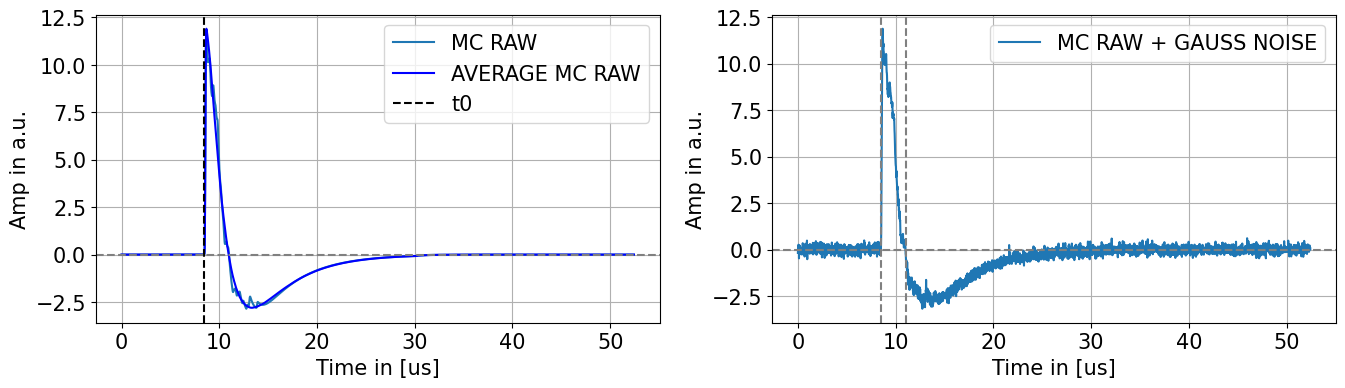

In [9]:
num = np.random.randint(0,MC_num)
i_base_idx,f_base_idx = find_baseline_cuts(my_run[0][0]["McNoiseADC"][num])
ave_wvf = np.mean(my_run[0][0]["McADC"],axis=0)
fig, ax = plt.subplots(1,2,figsize=(16,4))
# fig.suptitle("Standalone MC Simulation", fontsize="x-large")
ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McADC"][num])),my_run[0][0]["McADC"][num],c="tab:blue",label="MC RAW")
ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(ave_wvf)),ave_wvf,c="b",label="AVERAGE MC RAW")
# ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McADC"][num])),scfunc(np.arange(len(my_run[0][0]["McADC"][num])),*param),c="tab:orange",label="MC TEMPLATE")

ax[1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),my_run[0][0]["McNoiseADC"][num],c="tab:blue",label="MC RAW + GAUSS NOISE")
# ax[1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),scfunc(np.arange(len(my_run[0][0]["McNoiseADC"][num])),*param),c="tab:orange",label="MC TEMPLATE")
ax[1].axvline(1e6*my_run[0][0]["Sampling"]*i_base_idx,ls="--",color="grey")
ax[1].axvline(1e6*my_run[0][0]["Sampling"]*f_base_idx,ls="--",color="grey")
ax[0].axvline(1e6*my_run[0][0]["Sampling"]*(2*pre + 1)+1e3*my_run[0][0]["Mct0"][num],color="k",ls="--",label="t0")
# ax[1].axvline(1e6*my_run[0][0]["Sampling"]*np.argmax(my_run[0][0]["McNoiseADC"][num]),c="black",label="RISE TIME: %.2f"%(1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["McNoiseADC"][num])-i_base_idx)))

for i in range(len(ax)):
    ax[i].set_xlabel("Time in [us]")
    ax[i].set_ylabel("Amp in a.u.")
    ax[i].axhline(0,c="grey",ls="--")
    ax[i].legend()
# ax[0].set_title("Clean MC")
# ax[1].set_title("Noisy MC")
ax[0].grid(True)
ax[1].grid(True)
# ax[1].set_xlim([8,14])
plt.show()

In [10]:
OPT = {
    "NOISE_AMP": 0.5, # Noise amp as a factor of SPE max.
    "FIX_EXP":True,
    "WIENER_BUFFER": 200,
    "CONVERT_ADC": False
    }

OPT["FILTER"] = "WIENER"
KEY = ["McADC","FitSC","DecADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

KEY = ["McNoiseADC","FitSC","DecNoiseADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

OPT["FILTER"] = "GAUSS"
KEY = ["McADC","FitSC","DecADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)

KEY = ["McNoiseADC","FitSC","DecNoiseADC"]
deconvolve(my_run,my_run,my_run,KEY,OPT)


Generated wvfs with key WienerDecADC
Generated wvfs with key WienerDecNoiseADC
Generated wvfs with key GaussDecADC
Generated wvfs with key GaussDecNoiseADC


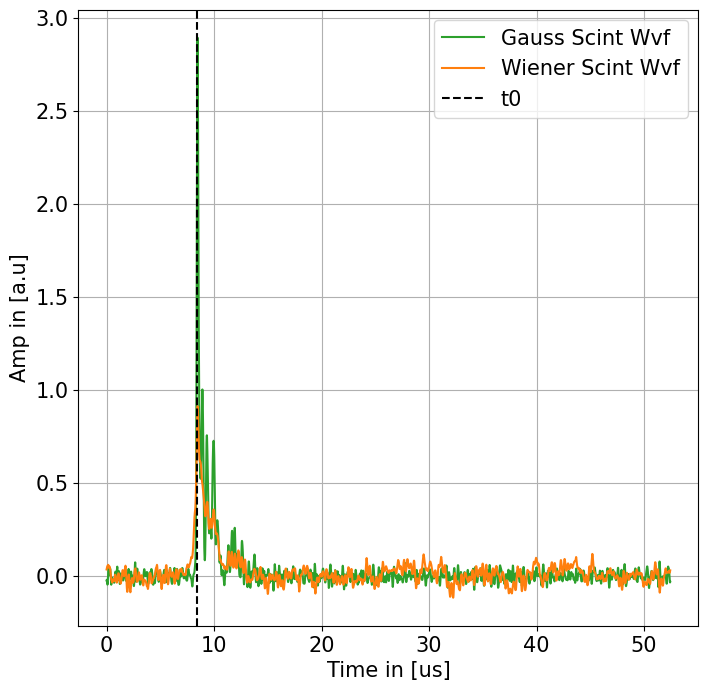

In [11]:
plt.plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["GaussDecNoiseADC"][0])),my_run[0][0]["GaussDecNoiseADC"][0],c="tab:green",label="Gauss Scint Wvf")
plt.plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["WienerDecNoiseADC"][0])),my_run[0][0]["WienerDecNoiseADC"][0],c="tab:orange",label="Wiener Scint Wvf")
plt.axvline(1e6*my_run[0][0]["Sampling"]*(2*pre)+1e3*my_run[0][0]["Mct0"][0],color="k",ls="--",label="t0")
plt.xlabel("Time in [us]")
plt.ylabel("Amp in [a.u]")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
opt = {"SHOW": False,
       "LOGY": True,
       "TERMINAL_OUTPUT": True
}
# filter_key = ["Wiener"]
filter_key = ["Gauss","Wiener"]
dec_key = ["GaussDecNoiseADC","WienerDecNoiseADC"]
# dec_key = ["WienerDecNoiseADC"]
for ii in range(len(dec_key)):
    my_run[0][0]["Ave"+dec_key[ii]] = []
    my_run[0][0]["Ave"+dec_key[ii]].append(np.mean(my_run[0][0][dec_key[ii]],axis=0))
    i_idx, f_idx = find_baseline_cuts(my_run[0][0]["Ave"+dec_key[ii]][0])   
    my_run[0][0]["ILimitAve"+filter_key[ii]] = i_idx
    my_run[0][0]["FLimitAve"+filter_key[ii]] = f_idx
    fit_wvfs(my_run,"Scint",1e-4,fit_range=[pretrigger,200],sigma = 5e-9, a_fast = 2e-7,a_slow = 3e-7,in_key=["Ave"+dec_key[ii]],out_key=dec_key[ii],OPT = opt)

Fitting wvf  0

--- FISRT FIT VALUES (FAST) ---
TIME:	8.32E-06	1.33E-09
SIGM:	8.90E-08	2.91E-08
AMP1:	4.94E-07	5.16E+01
TAU1:	9.32E-09	3.46E-01
-------------------------------

--- SECOND FIT VALUES (SLOW) ---
SIGM:	8.05E-08	4.45E-09
AMP1:	5.11E-07	4.17E-07
tau1:	8.98E-09	1.67E-10
AMP2:	2.53E-07	1.96E-08
tau2:	1.57E-06	2.01E-07
--------------------------------



Fitting wvf  0

--- FISRT FIT VALUES (FAST) ---
TIME:	8.31E-06	2.57E-09
SIGM:	7.56E-08	4.67E-08
AMP1:	1.54E-07	9.33E-05
TAU1:	8.06E-09	1.24E-06
-------------------------------

--- SECOND FIT VALUES (SLOW) ---
SIGM:	8.31E-08	5.89E-09
AMP1:	1.41E-07	6.02E-06
tau1:	8.12E-09	3.20E-08
AMP2:	2.80E-07	4.43E-08
tau2:	1.20E-06	2.11E-07
--------------------------------





/home/smanthey/Code/CYTHON_TOOLS/notebooks/../lib/fit_functions.py:44: RuntimeWarning: overflow encountered in exp
  return (2 * a/tau)*np.exp((sigma/(np.sqrt(2)*tau))**2-(np.array(t)-t0)/tau)*(1-erf((sigma**2-tau*(np.array(t)-t0))/(np.sqrt(2)*sigma*tau)))
/home/smanthey/Code/CYTHON_TOOLS/notebooks/../lib/fit_functions.py:44: RuntimeWarning: overflow encountered in multiply
  return (2 * a/tau)*np.exp((sigma/(np.sqrt(2)*tau))**2-(np.array(t)-t0)/tau)*(1-erf((sigma**2-tau*(np.array(t)-t0))/(np.sqrt(2)*sigma*tau)))
/home/smanthey/Code/CYTHON_TOOLS/notebooks/../lib/fit_functions.py:44: RuntimeWarning: invalid value encountered in multiply
  return (2 * a/tau)*np.exp((sigma/(np.sqrt(2)*tau))**2-(np.array(t)-t0)/tau)*(1-erf((sigma**2-tau*(np.array(t)-t0))/(np.sqrt(2)*sigma*tau)))


In [13]:
raw_key = ["McNoiseADC","GaussDecNoiseADC","WienerDecNoiseADC"]
wvf_key = ["Raw","Gauss","Wiener"]

for j in range(len(raw_key)):
    my_run[0][0][wvf_key[j]+"Charge"] = []
    my_run[0][0][wvf_key[j]+"Amp"] = []
    my_run[0][0][wvf_key[j]+"Time"] = [] 
    my_run[0][0][wvf_key[j]+"NoiseSTD"] = [] 
    for i in range(len(my_run[0][0][raw_key[j]])):
        i_base_idx,f_base_idx = find_baseline_cuts(my_run[0][0][raw_key[j]][i])
        amp = np.max(my_run[0][0][raw_key[j]][i])
        time = my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0][raw_key[j]][i])-2*pre + 1) - my_run[0][0]["Mct0"][i]
        noiseSTD = np.std(my_run[0][0][raw_key[j]][i][:i_base_idx])
        if raw_key[j] == "McNoiseADC":
            charge = np.sum(my_run[0][0][raw_key[j]][i][i_base_idx:f_base_idx])
            my_run[0][0][wvf_key[j]+"Charge"].append(my_run[0][0]["Sampling"]*charge/my_run[0][0]["SPEChargeADC"]) 
        else:
            charge = np.sum(my_run[0][0][raw_key[j]][i][:my_run[0][0]["FLimitAveGauss"]])
            my_run[0][0][wvf_key[j]+"Charge"].append(charge)
        my_run[0][0][wvf_key[j]+"Amp"].append(amp)
        my_run[0][0][wvf_key[j]+"Time"].append(time*1e9)
        my_run[0][0][wvf_key[j]+"NoiseSTD"].append(noiseSTD)
    my_run[0][0][wvf_key[j]+"Charge"]   = np.asarray(my_run[0][0][wvf_key[j]+"Charge"])
    my_run[0][0][wvf_key[j]+"Amp"]      = np.asarray(my_run[0][0][wvf_key[j]+"Amp"])
    my_run[0][0][wvf_key[j]+"Time"]     = np.asarray(my_run[0][0][wvf_key[j]+"Time"])
    my_run[0][0][wvf_key[j]+"NoiseSTD"] = np.asarray(my_run[0][0][wvf_key[j]+"NoiseSTD"])

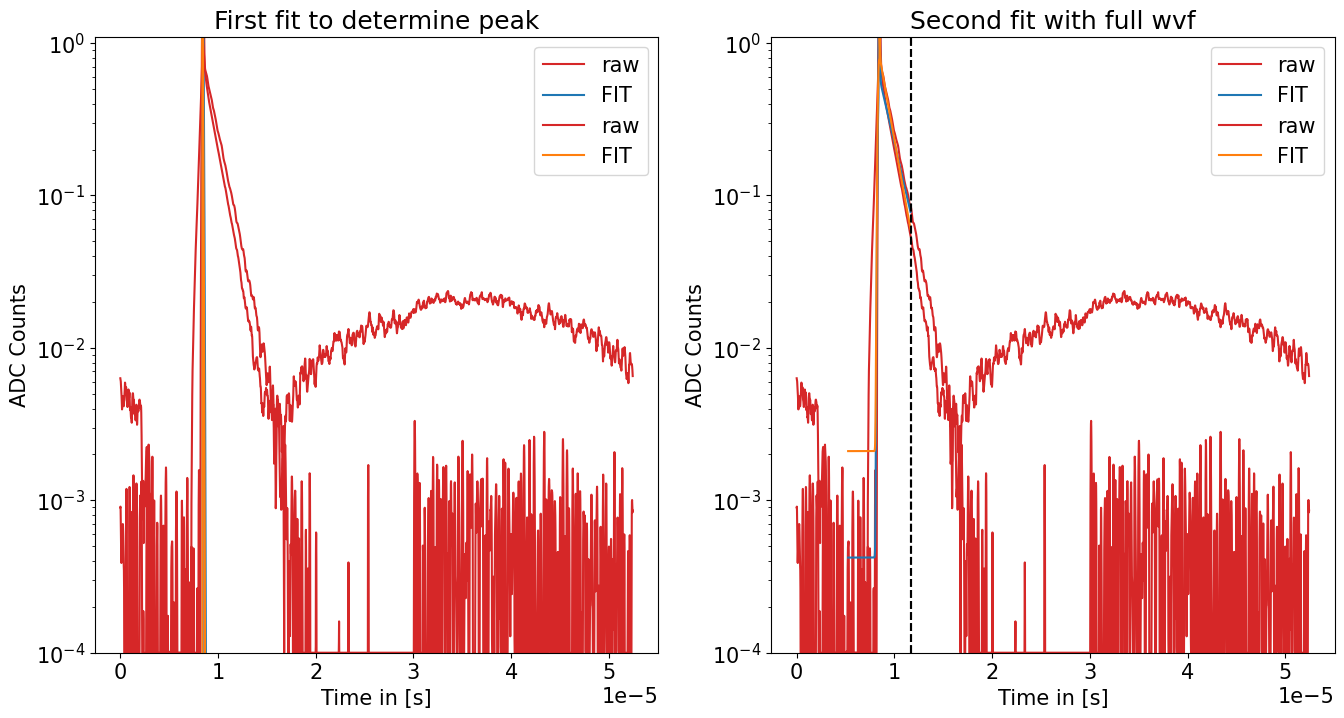

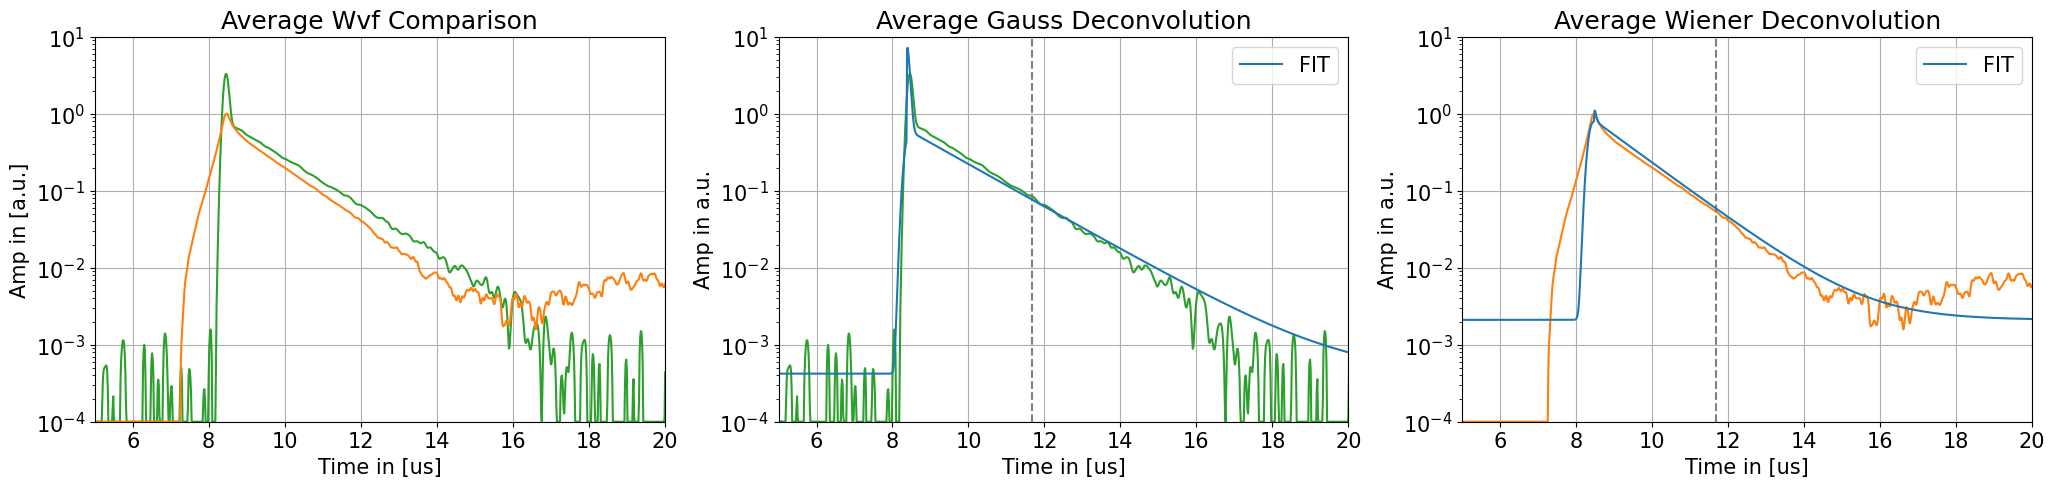

In [14]:
# %matplotlib qt
dec_key = ["GaussDecNoiseADC","WienerDecNoiseADC"]
color = ["tab:green","tab:orange"]

fig,ax = plt.subplots(1,3,figsize=(25,5))
for i in range(len(ax)-1):
    ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Ave"+dec_key[i]][0])),my_run[0][0]["Ave"+dec_key[i]][0],c=color[i],label=dec_key[i])
    ax[i+1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Ave"+dec_key[i]][0])),my_run[0][0]["Ave"+dec_key[i]][0],c=color[i])
    ax[i+1].axvline(1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["Ave"+dec_key[i]][0])+200),ls="--",c="grey")
    ax[i+1].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitScint"+dec_key[i]][0])),my_run[0][0]["FitScint"+dec_key[i]][0],label="FIT")
    ax[i+1].semilogy()
    ax[i+1].set_ylim([1e-4,1e1]) 
    ax[i+1].set_xlabel("Time in [us]")
    ax[i+1].set_ylabel("Amp in a.u.")
    ax[i+1].axhline(0,c="grey",ls="--")
    ax[i+1].grid(True)
    ax[i+1].set_xlim([5,20])
    ax[i+1].legend()
ax[0].grid(True)
ax[0].set_xlim([5,20])
ax[0].set_ylim([1e-4,1e1])
ax[0].semilogy()
ax[0].set_ylabel("Amp in [a.u.]")
ax[0].set_xlabel("Time in [us]")
ax[0].set_title("Average Wvf Comparison")
ax[1].set_title("Average Gauss Deconvolution")
ax[2].set_title("Average Wiener Deconvolution")
plt.show()


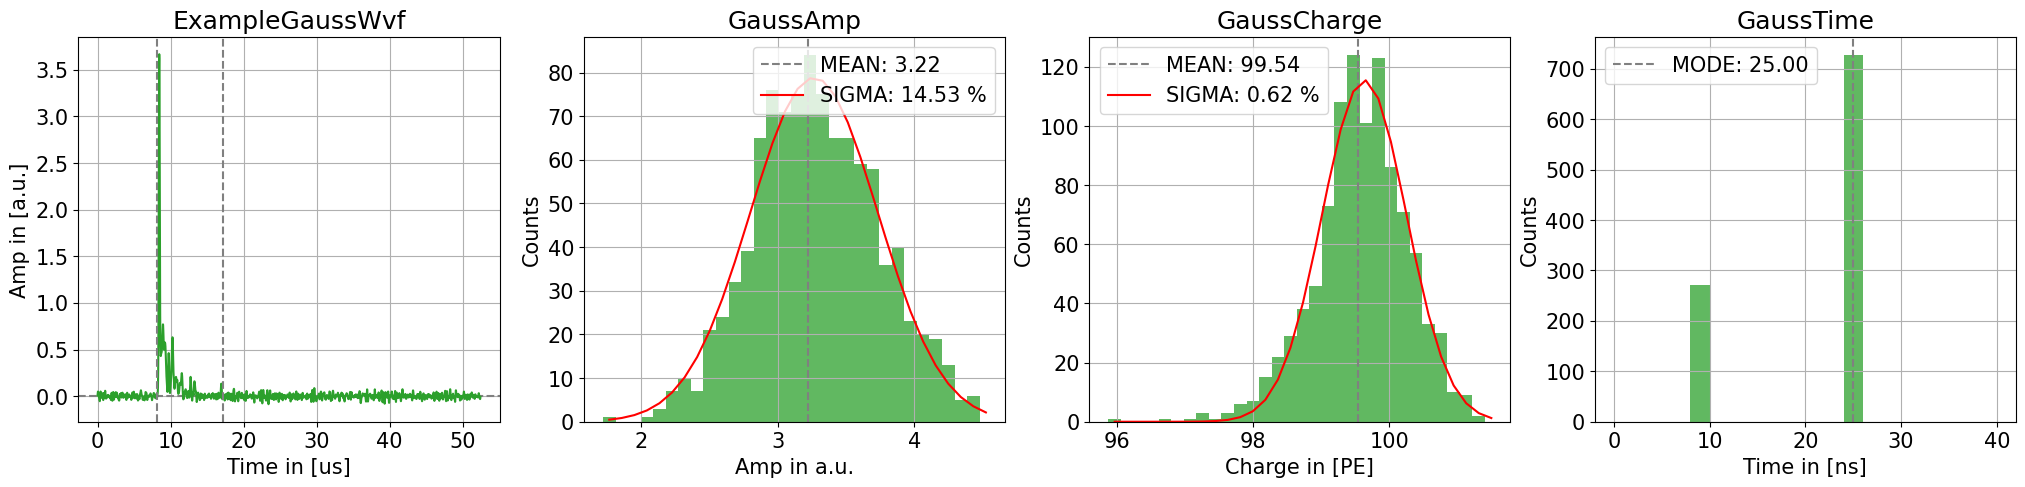

In [18]:
# %matplotlib qt
sigma = [1,50,1e-9]
# num = np.random.randint(0,MC_num)
num = np.random.randint(0,1000)

# filter_key = "Raw"; color = "tab:blue"
filter_key = "Gauss"; color = "tab:green"
# filter_key = "Wiener"; color = "tab:orange"
dec_key = "DecNoiseADC"

key_value = [filter_key+"Amp",filter_key+"Charge",filter_key+"Time"]
x_label = ["Amp in a.u.","Charge in [PE]","Time in [ns]"]

fig,ax = plt.subplots(1,4,figsize=(25,5))
ax[0].grid(True)
ax[0].axhline(0,ls="--",c="grey")
if filter_key == "Raw":
    t0_bins = np.arange(0,np.max(my_run[0][0][key_value[i-1]]),16)
    ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["McNoiseADC"][num])),my_run[0][0]["McNoiseADC"][num],c="tab:blue",label="MC NOISE")

else:
    t0_bins = np.arange(0,np.max(my_run[0][0][key_value[i-1]]),2)
    ax[0].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][filter_key+dec_key][num])),my_run[0][0][filter_key+dec_key][num],c=color,label="MC NOISE")
    ax[0].axvline(1e6*my_run[0][0]["ILimitAve"+filter_key]*my_run[0][0]["Sampling"],c="grey",ls="--")
    ax[0].axvline(1e6*my_run[0][0]["FLimitAveGauss"]*my_run[0][0]["Sampling"],c="grey",ls="--")
for i in range(1,len(ax)):
    if i == 1 or i == 2 :
        n,bins,patches = ax[i].hist(my_run[0][0][key_value[i-1]],bins=30,alpha=0.75,color=color)
        initial = [np.max(n)*sigma[i-1],bins[np.argmax(n)+1],sigma[i-1]]
        gauss_fit_labels = ["Amp:\t","Mean:\t","Sigma:\t"]
        try:
            popt2, pcov2 = curve_fit(gauss,bins[:-1],n,p0=initial)
        except:
            print("FIT COULD NOT BE PERFORMED"); popt2 = initial
        # for j in range(len(popt2)): print(gauss_fit_labels[j],"{:.2E}".format(popt2[j]))
        # if i == 2: print("#PE: %.2f"%(popt2[1]/my_run[0][0]["SPECharge"]))
        ax[i].axvline(popt2[1],c="grey",ls="--",label="MEAN: %.2f"%abs(popt2[1]))
        ax[i].plot(bins+(bins[1]-bins[0])/2,gauss(bins,*popt2),c="red",label="SIGMA: %.2f %%"%abs(100*popt2[2]/popt2[1]))

    else:
        # t0_bins = np.arange(-6,60,6)
        n,bins,patches = ax[i].hist(my_run[0][0][key_value[i-1]],bins=t0_bins,alpha=0.75,color=color)
        # n,bins,patches = ax[i].hist(my_run[0][0][key_value[i-1]],alpha=0.75,color=color)
        ax[i].axvline(bins[np.argmax(n)]+bins[1]/2,c="grey",ls="--",label="MODE: %.2f"%(bins[np.argmax(n)]+bins[1]/2))
        # ax[i].axvline(np.mean(my_run[0][0][key_value[i-1]]),c="grey",ls="--",label="MEAN: %.2f"%np.mean(my_run[0][0][key_value[i-1]]))
        # ax[i].axvline(np.std(my_run[0][0][key_value[i-1]]),c="grey",ls="--",label="STD: %.2f"%np.std(my_run[0][0][key_value[i-1]]))
        # ax[i].axvline(np.bincount(my_run[0][0][key_value[i-1]]).argmax(),c="grey",ls="--",label="MAX: %.2f"%np.bincount(my_run[0][0][key_value[i-1]]).argmax())
    ax[i].legend()
    ax[i].set_title(key_value[i-1])
    ax[i].set_xlabel(x_label[i-1])
    ax[i].set_ylabel("Counts")
    ax[i].grid(True,which="both")

ax[0].set_title("Example" + filter_key + "Wvf")
# ax[2].set_xlim([50,110])
# ax[3].semilogy()
# ax[3].set_ylim([1e-1,1e3])
# ax[3].set_xlim([0,65])
ax[0].set_xlabel("Time in [us]")
ax[0].set_ylabel("Amp in [a.u.]")
plt.show()

# print(my_run[0][0][key_value[i-1]])

In [16]:
signal_to_noise = np.mean(my_run[0][0]["WienerAmp"])/np.mean(my_run[0][0]["WienerNoiseSTD"])
print(signal_to_noise)

26.92314069193622
